# Chapter 09 텍스트를 위한 인공 신경망

## 09-2 순환 신경망으로 IMDB 리뷰 분류하기

**말뭉치**<br>
자연어 처리에서 사용하는 텍스트의 모음, 즉 훈련 데이터셋을 일컫음

**토큰**<br>
텍스트에서 공백으로 구분되는 문자열   
=> 종종 소문자로 변환하고 구둣점은 삭제함

**원-핫 인코딩**<br>
어떤 클래스에 해당하는 원소만 1이고 나머지는 모두 0인 벡터   
=> 정수로 변환된 원-핫 인코딩으로 변환하려면 어휘 사전 크기의 벡터가 만들어짐

**단어 임베딩**<br>
정수로 변환된 토큰을 비교적 작은 크기의 실수 밀집 벡터로 변환   
=> 밀집 벡터는 단어 사이의 관계를 표현할 수 있기 때문에 자연어 처리에서 좋은 성능을 발휘함

### IMDB 리뷰 데이터셋

In [1]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=200)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [3]:
print(len(train_input[0]))

218


In [4]:
print(len(train_input[1]))

189


In [5]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 2, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 2, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 2, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 2, 92, 25, 104, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [6]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [7]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [8]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [9]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


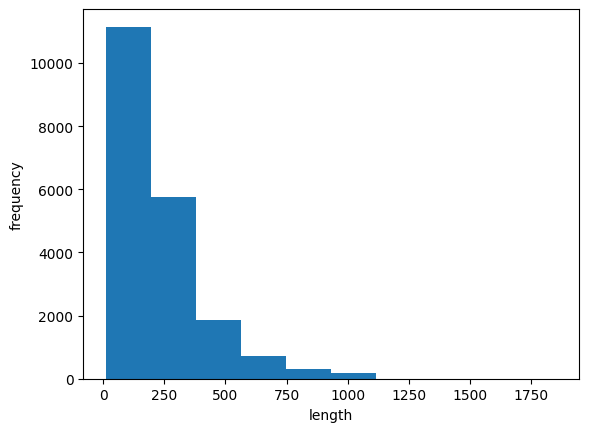

In [10]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

In [12]:
print(train_seq.shape)

(20000, 100)


In [13]:
print(train_seq[0])

[ 10   4  20   9   2   2   2   5  45   6   2   2  33   2   8   2 142   2
   5   2  17  73  17   2   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12   2  69   2 142  73   2   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [14]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


In [15]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71   2   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14   2  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94   2   2  10  10  87   2  34  49   2   7   2   2   2
   2   2   2   2  46  48  64  18   4   2]


In [16]:
val_seq = pad_sequences(val_input, maxlen=100)

### 순환 신경망 만들기

In [17]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 200)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
train_oh = keras.utils.to_categorical(train_seq)

In [19]:
print(train_oh.shape)

(20000, 100, 200)


In [20]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [21]:
print(np.sum(train_oh[0][0]))

1.0


In [22]:
val_oh = keras.utils.to_categorical(val_seq)

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

### 순환 신경망 훈련하기

In [24]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.4915 - loss: 0.7030 - val_accuracy: 0.4878 - val_loss: 0.7006
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4965 - loss: 0.6976 - val_accuracy: 0.4964 - val_loss: 0.6972
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5045 - loss: 0.6950 - val_accuracy: 0.4988 - val_loss: 0.6957
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5044 - loss: 0.6941 - val_accuracy: 0.5022 - val_loss: 0.6946
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5120 - loss: 0.6927 - val_accuracy: 0.5082 - val_loss: 0.6938
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5103 - loss: 0.6925 - val_accuracy: 0.5184 - val_loss: 0.6930
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.5282 - loss: 0.6909 - val_accuracy: 0.5138 - val_loss: 0.6928
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.5279 - loss: 0.690

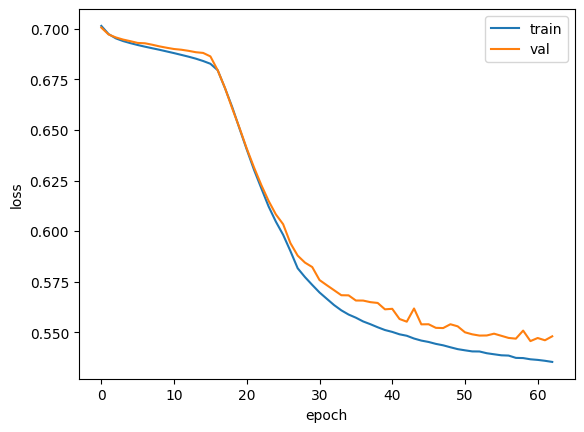

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [26]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 3200000000


### 단어 임베딩을 사용하기

In [27]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(200, 16, input_shape=(100,)))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,409 (13.32 KB)

 Trainable params: 3,409 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.5268 - loss: 0.6912 - val_accuracy: 0.6002 - val_loss: 0.6694
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6236 - loss: 0.6593 - val_accuracy: 0.6562 - val_loss: 0.6413
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6671 - loss: 0.6358 - val_accuracy: 0.6846 - val_loss: 0.6210
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6931 - loss: 0.6143 - val_accuracy: 0.6958 - val_loss: 0.6040
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.6950 - loss: 0.6025 - val_accuracy: 0.7022 - val_loss: 0.5900
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.7137 - loss: 0.5847 - val_accuracy: 0.7076 - val_loss: 0.5841
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7040 - loss: 0.5837 - val_accuracy: 0.6990 - val_loss: 0.5891
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7153 - loss: 0.

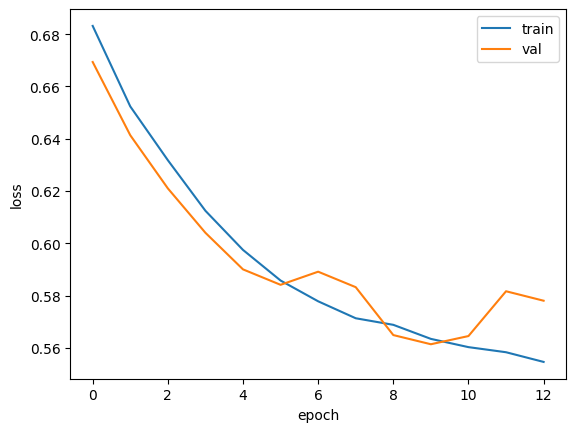

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 09-3 LSTM과 GRU 셀

### LSTM 구조

“Long Short-Term Memory”의 줄임말

**오래된 정보도 잘 기억할 수 있는 RNN(순환 신경망)**

---

**왜 필요할까?**

일반적인 RNN은 시간이 지나면 이전 정보가 잘 기억되지 않는 문제가 있었어요.   
예를 들어, 긴 문장을 처리하다 보면 문장의 앞부분을 잘 잊어버려요.

---

**LSTM 구조 쉽게 이해하기**

LSTM은 ‘**정보를 얼마나 기억하고, 얼마나 버릴지 결정하는 장치(게이트)**’를 갖고 있음

---

**핵심은 "3개의 게이트 + 셀 상태"**

| 구성 요소              | 역할                                   | 쉽게 말하면...           |
|-----------------------|----------------------------------------|---------------------------|
| 셀 상태 | 정보가 흐르는 메인 통로                 | "기억 저장소"            |
| Forget 게이트 | 과거 정보를 얼마나 잊을지 결정          | "이건 버려도 돼!"        |
| 입력 게이트 | 새로운 정보를 얼마나 기억할지 결정       | "이건 새로 저장할래!"    |
| 출력 게이트 | 다음 단계로 어떤 정보를 내보낼지 결정    | "이것만 보여줄게!"       |

---

**LSTM의 정보 흐름 과정**

1. **이전의 기억($c_{t-1}$)과 현재 정보($x_t$)를 받음**
2. **Forget 게이트**: “이건 중요하지 않으니까 잊자!”
3. **입력 게이트**: “이건 새로 배운 정보니까 저장하자!”
4. **셀 상태 업데이트**: “예전 기억 중 중요한 것 + 새로 배운 것만 남겨두자!”
5. **출력 게이트**: “이번엔 이 정보만 다음으로 보내자!”

=> 이 과정을 통해 **오래된 중요한 정보는 유지하고, 불필요한 정보는 잊을 수 있음**


### LSTM 신경망 훈련하기

In [31]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [33]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5218 - loss: 0.6927 - val_accuracy: 0.5740 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5952 - loss: 0.6900 - val_accuracy: 0.6132 - val_loss: 0.6876
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.6333 - loss: 0.6854 - val_accuracy: 0.6490 - val_loss: 0.6788
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.6564 - loss: 0.6738 - val_accuracy: 0.6992 - val_loss: 0.6456
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.7090 - loss: 0.6225 - val_accuracy: 0.7120 - val_loss: 0.5771
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.7302 - loss: 0.5678 - val_accuracy: 0.7358 - val_loss: 0.5524
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.7503 - loss: 0.5441 - val_accuracy: 0.7526 - val_loss: 0.5322
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7674 - loss: 0

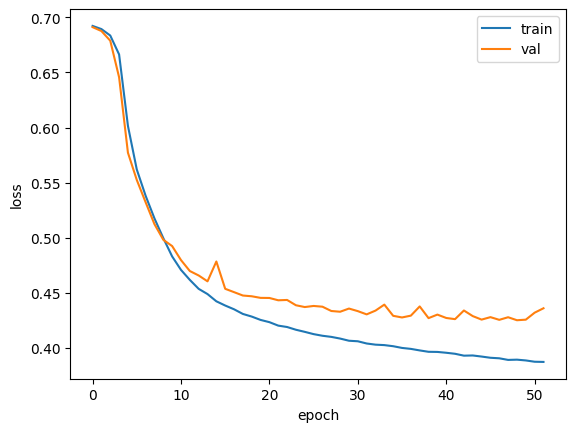

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 순환층에 드롭아웃 적용하기

In [37]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [38]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best_dropout_model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5438 - val_loss: 0.6923
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5628 - loss: 0.6919 - val_accuracy: 0.5966 - val_loss: 0.6906
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.5861 - loss: 0.6899 - val_accuracy: 0.6254 - val_loss: 0.6871
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.6196 - loss: 0.6852 - val_accuracy: 0.6580 - val_loss: 0.6779
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.6570 - loss: 0.6721 - val_accuracy: 0.7132 - val_loss: 0.6349
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.6971 - loss: 0.6238 - val_accuracy: 0.7212 - val_loss: 0.5893
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7142 - loss: 0.5899 - val_accuracy: 0.7400 - val_loss: 0.5705
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.7374 - loss: 0

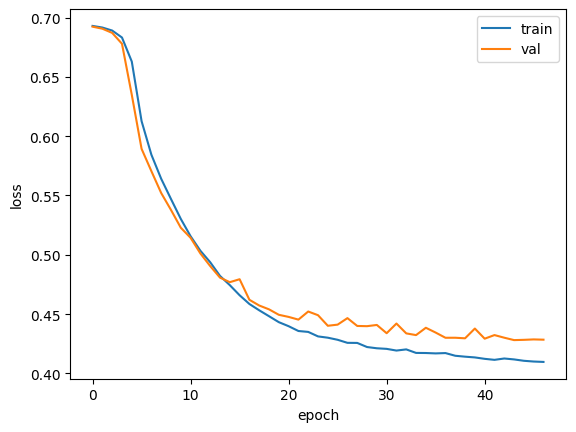

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 2개의 층을 연결하기

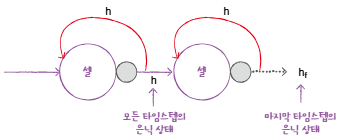

- **문장 전체의 특징을 알고 싶다면** → 마지막 타임스텝만 사용
- **모든 시점의 정보를 사용하려면** → 전체 타임스텝의 h값 사용

In [40]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [41]:
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.5123 - loss: 0.6930 - val_accuracy: 0.5562 - val_loss: 0.6925
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.5430 - loss: 0.6921 - val_accuracy: 0.5858 - val_loss: 0.6904
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.5797 - loss: 0.6886 - val_accuracy: 0.6394 - val_loss: 0.6784
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.6355 - loss: 0.6672 - val_accuracy: 0.6980 - val_loss: 0.6040
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.6954 - loss: 0.5971 - val_accuracy: 0.7292 - val_loss: 0.5490
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.7310 - loss: 0.5506 - val_accuracy: 0.7522 - val_loss: 0.5172
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.7498 - loss: 0.5249 - val_accuracy: 0.7626 - val_loss: 0.4979
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.7694 - loss: 0

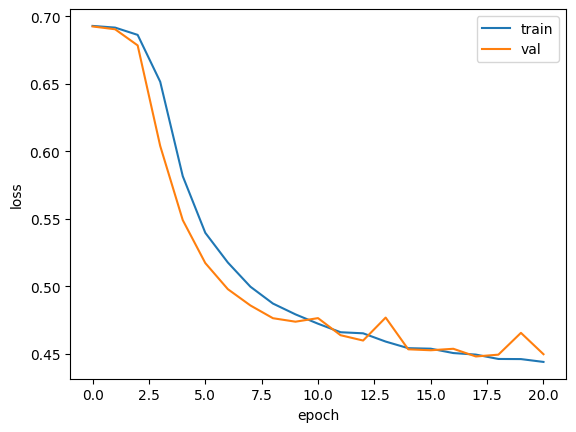

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### GRU 구조

“Gated Recurrent Unit”의 약자

LSTM보다 더 간단하고 계산량이 적은 버전

LSTM은 **셀 상태(c)**와 **은닉 상태(h)**를 모두 다루지만,   
GRU는 **은닉 상태(h)**만 사용함

---

**GRU 셀 구성 요소**

GRU는 내부에 **게이트(gate)**라는 문을 사용해서 정보를 선택적으로 기억하거나 잊음

| 구성 요소               | 역할                                        | 설명                     |
|------------------------|---------------------------------------------|--------------------------|
| 업데이트 게이트 (z) | 얼마나 이전 은닉 상태를 유지할지 결정        | “기억할까? 말까?” 결정   |
| 리셋 게이트 (r) | 얼마나 과거 정보를 무시할지 결정             | “이건 잊어도 돼!” 판단   |
| 후보 은닉 상태 (h̃) | 현재 입력을 바탕으로 새 은닉 상태 후보 계산 | `tanh` 함수 사용          |

---

**GRU의 작동 흐름 요약**

1. **입력($x$)**과 **이전 은닉 상태($h_{t-1}$)**를 기반으로  
   → 업데이트 게이트 `z`와 리셋 게이트 `r` 계산

2. 리셋 게이트 `r`를 이용해 과거 정보를 일부 무시하고,  
   → 새로운 후보 은닉 상태 `h̃` 생성

3. 업데이트 게이트 `z`를 이용해  
   → 기존 은닉 상태와 후보 은닉 상태를 적절히 섞어서 **최종 은닉 상태($h_t$)** 결정

---

**GRU vs LSTM**

| 항목       | LSTM                           | GRU                        |
|------------|--------------------------------|----------------------------|
| 상태       | 셀 상태(c), 은닉 상태(h)       | 은닉 상태(h)만            |
| 게이트 수  | 3개 (입력, 삭제, 출력)         | 2개 (업데이트, 리셋)      |
| 계산량     | 더 많음                         | 더 적음                   |
| 학습 속도  | 느릴 수 있음                    | 더 빠름                   |
| 성능       | 복잡한 문제에 강함              | 가벼운 문제에 효과적      |

### GRU 신경망 훈련하기

In [45]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [46]:
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.5060 - loss: 0.6929 - val_accuracy: 0.5492 - val_loss: 0.6913
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5504 - loss: 0.6910 - val_accuracy: 0.5742 - val_loss: 0.6896
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5674 - loss: 0.6889 - val_accuracy: 0.5824 - val_loss: 0.6863
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5884 - loss: 0.6850 - val_accuracy: 0.5908 - val_loss: 0.6815
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.6038 - loss: 0.6788 - val_accuracy: 0.6016 - val_loss: 0.6739
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.6153 - loss: 0.6701 - val_accuracy: 0.6164 - val_loss: 0.6623
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.6379 - loss: 0.6553 - val_accuracy: 0.6410 - val_loss: 0.6452
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.6548 - loss: 0

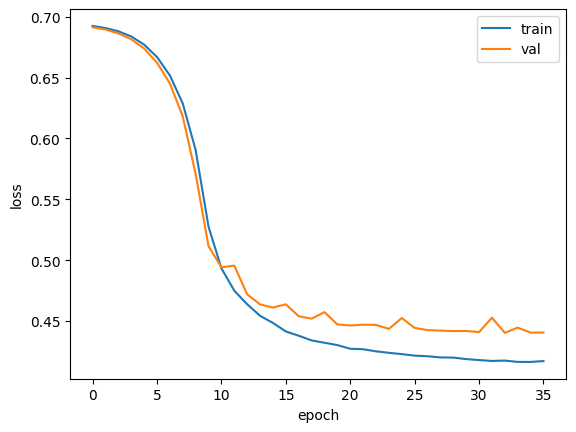

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [49]:
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.keras')
rnn_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7925 - loss: 0.4448


[0.44635170698165894, 0.7919600009918213]